In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import re
import glob
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from fit_generator import label_from_id
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.callbacks import ModelCheckpoint 
from fnn_helper import PlotLosses
from keras import regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy

Using TensorFlow backend.


In [3]:
Y = np.load('y.npy')
NUM_CATEGORIES = Y.shape[1]

In [4]:
doc_term = scipy.io.mmread('countvect-articles')
(NUM_ARTICLES, NUM_WORDS) = doc_term.shape

# CountVectorizer como entrada de la red neuronal

Hasta acá tenemos:

* doc_term: matriz de (NUM_ARTICLES, NUM_WORDS) con los count de cada word
* Y: matriz de (NUM_ARTICLES, NUM_CATEGORIES) con los labels

In [5]:
x_train, x_test, y_train, y_test = train_test_split(doc_term, Y, test_size=0.33)

In [6]:
def build_model(layers, optimizer_method, lr=0.1, decay=0.0, model=None):
    if model == None:
        model = Sequential()
        for layer in layers:
            model.add(layer)

    optimizer = optimizer_method(lr=lr, decay=decay)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [7]:
def batch_generator(X, y, samples_per_epoch, batch_size):
    number_of_batches = samples_per_epoch // batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [8]:
def train_model(model, x_train, x_test, y_train, y_test, weights_file=None, batch_size=16, epochs=10):
    plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)
    callbacks = [plot_losses]

    if weights_file != None:
        checkpointer = ModelCheckpoint(filepath=weights_file, verbose=0, save_best_only=True)
        callbacks.append(checkpointer)

    steps_per_epoch = x_train.shape[0] // batch_size
    print("Steps per epoch = ", steps_per_epoch)
    generator = batch_generator(x_train, y_train, samples_per_epoch=steps_per_epoch, batch_size=batch_size)
    vals_per_epoc = x_test.shape[0] // batch_size
    val_generator = batch_generator(x_test, y_test, samples_per_epoch=vals_per_epoc, batch_size=batch_size)
    result = model.fit_generator(
        generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=vals_per_epoc,
        verbose=1,
        callbacks=callbacks,
    )
    return result

In [9]:
model = build_model(
    [
        Dense(NUM_CATEGORIES, input_dim=NUM_WORDS, activation='sigmoid'),
    ],
    optimizers.SGD,
    lr=0.002)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 302440    
Total params: 302,440
Trainable params: 302,440
Non-trainable params: 0
_________________________________________________________________


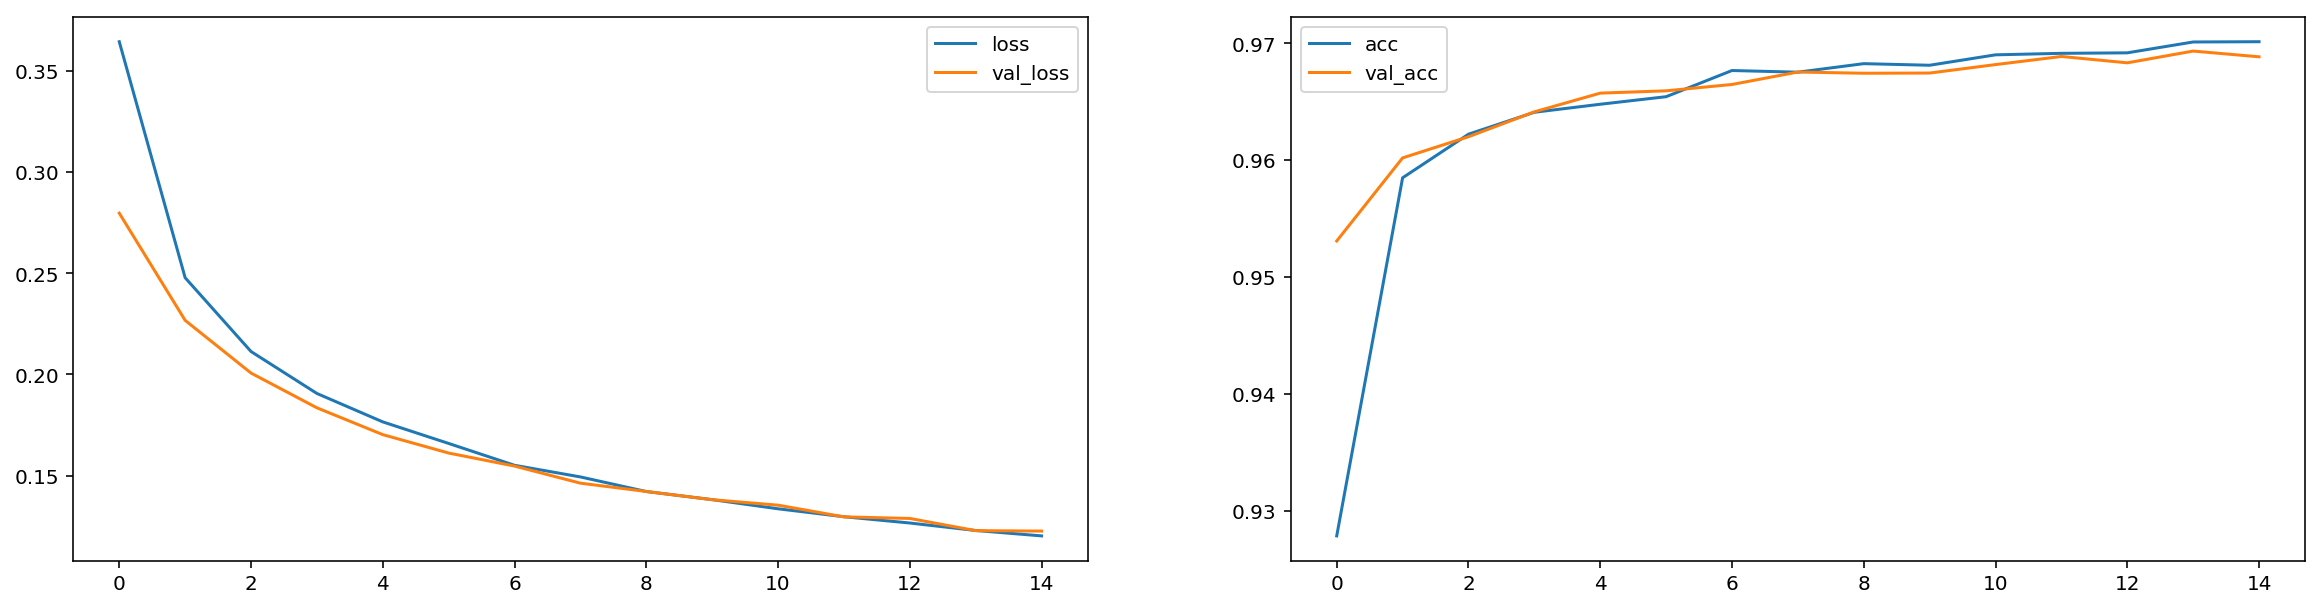

2193/2193 [==============================] - 43s - loss: 0.1202 - acc: 0.9701 - val_loss: 0.1226 - val_acc: 0.9688
Epoch 16/100
1363/2193 [=================>............] - ETA: 12s - loss: 0.1171 - acc: 0.9702

KeyboardInterrupt: 

In [10]:
train_model(model, x_train, x_test, y_train, y_test, weights_file='countvect1.weights', batch_size=32, epochs=100)

In [ ]:
# def multi_category_accuracy(y_true, y_pred):
#     result = []
#     active_labels = (y_true > 1/(len(y_true[0])+1))
#     sorted_pred = np.argsort(y_pred)[::-1]

#     for i, row in enumerate(active_labels):
#         num_active = row.sum()
#         intersec = set(sorted_pred[i][0:num_active]) & set(np.where(active_labels[i] == True)[0])
#         result.append(len(intersec) / num_active)
        
#     return np.array(result).mean()

In [ ]:
model2 = build_model(
    [
        Dense(NUM_CATEGORIES, input_dim=NUM_WORDS, activation='sigmoid'),
    ],
    optimizers.SGD,
    lr=0.002,
    model=model2)

In [ ]:
train2 = train_model(model2, x_train, x_test, y_train, y_test,
                    weights_file='countvect2.weights', batch_size=32, epochs=50)

In [ ]:
predictions = model2.predict(x_test[dobles].todense()) > .5
predictions = predictions * 1.0
predictions

In [ ]:
dobles = np.where(y_test.sum(axis=1) > 1)[0]


In [ ]:
y_test[dobles]

In [ ]:
((y_test[dobles] == predictions).sum(axis=1) != 5).sum()

In [ ]:
1216 / len(y_test)

In [ ]:
dobles